In [1]:
from google.colab import files
uploaded = files.upload()


Saving data_mv_set.csv to data_mv_set.csv


In [3]:
import io
import pandas as pd

dataset = pd.read_csv(io.BytesIO(uploaded['data_mv_set.csv']))
dataset.head()

,uuid,exchange,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,volume_avg_today,volume_avg_24h,trades_today,trades_24h,low_today,low_24h,high_today,high_24h,opening_price,ts
0,9831925d-f9b1-4fde-9d40-34c5dc222a91,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,94508.35523,176635.0497,1087,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
1,63644912-c186-4a7c-a0fd-739520c879b6,kraken,0.000804,334,334,0.000802,150,150,0.000805,150,103094.91810,176635.0497,1196,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
2,8150086e-98d8-4dd3-91fa-111923a6f78c,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,103094.95470,176635.0497,1198,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
3,6df11107-1be2-4e31-97a6-d20e80431b14,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103249.37390,176635.0497,1199,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
4,2d2358d9-dec6-49be-b309-33db96b75eaa,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103279.59390,176635.0497,1200,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487


In [4]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model

In [5]:
del dataset['uuid']
del dataset['exchange']
del dataset['volume_avg_today']
del dataset['volume_avg_24h']
del dataset['trades_today']
del dataset['trades_24h']
del dataset['low_today']
del dataset['low_24h']
del dataset['high_today']
del dataset['high_24h']
del dataset['opening_price']
print(dataset.shape)

In [6]:
# We will divide the data into 80% training and 20% testing data.

n_train_rows = int(dataset.shape[0]*.8)-1

train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]

print(train.shape)
print(test.shape)

(26638, 9)
(6661, 9)


In [7]:
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

In [8]:
steps = 50

#Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0]-steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

(26538, 50, 9)


In [9]:
# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(6611, 50, 9)


In [10]:
model = Sequential()

epochs = 10

#training and making Model
model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],9)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=9))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)
model.summary

model.save("multiple_features_"+str(steps)+"_steps_"+str(epochs)+"_epochs.h5")
print("Saved model to disk")

Epoch 1/10
830/830 [==============================] - 80s 97ms/step - loss: 0.0325
Epoch 2/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0251
Epoch 3/10
830/830 [==============================] - 82s 98ms/step - loss: 0.0229
Epoch 4/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0223
Epoch 5/10
830/830 [==============================] - 82s 99ms/step - loss: 0.0220
Epoch 6/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0219
Epoch 7/10
830/830 [==============================] - 80s 97ms/step - loss: 0.0218
Epoch 8/10
830/830 [==============================] - 80s 96ms/step - loss: 0.0216
Epoch 9/10
830/830 [==============================] - 81s 98ms/step - loss: 0.0216
Epoch 10/10
830/830 [==============================] - 80s 96ms/step - loss: 0.0215
Saved model to disk


In [11]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
207/207 [==============================] - 5s 23ms/step - loss: 0.0175
test loss, test acc: 0.017475662752985954


In [33]:
# Predict values from test data trained using training data
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

(6611, 9)

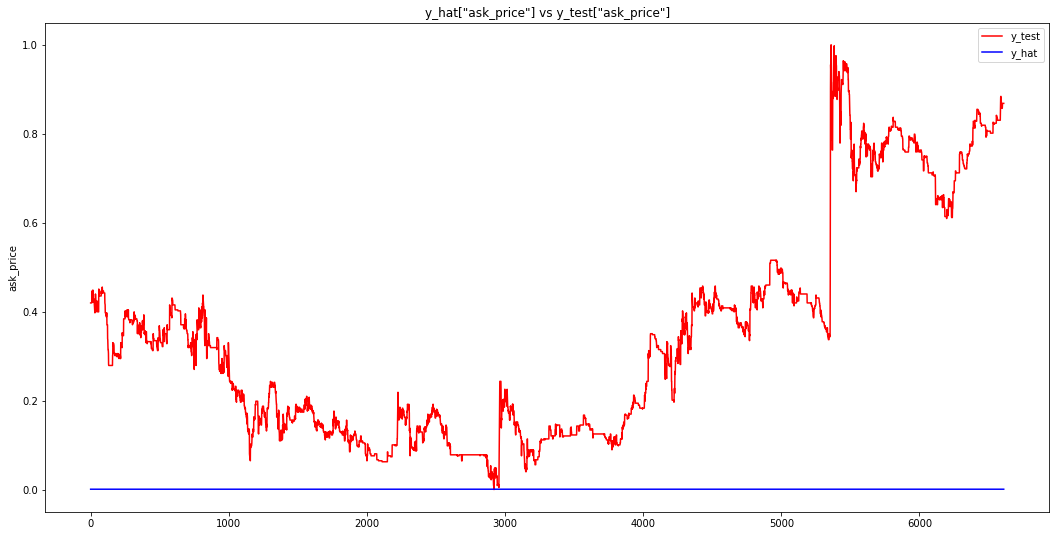

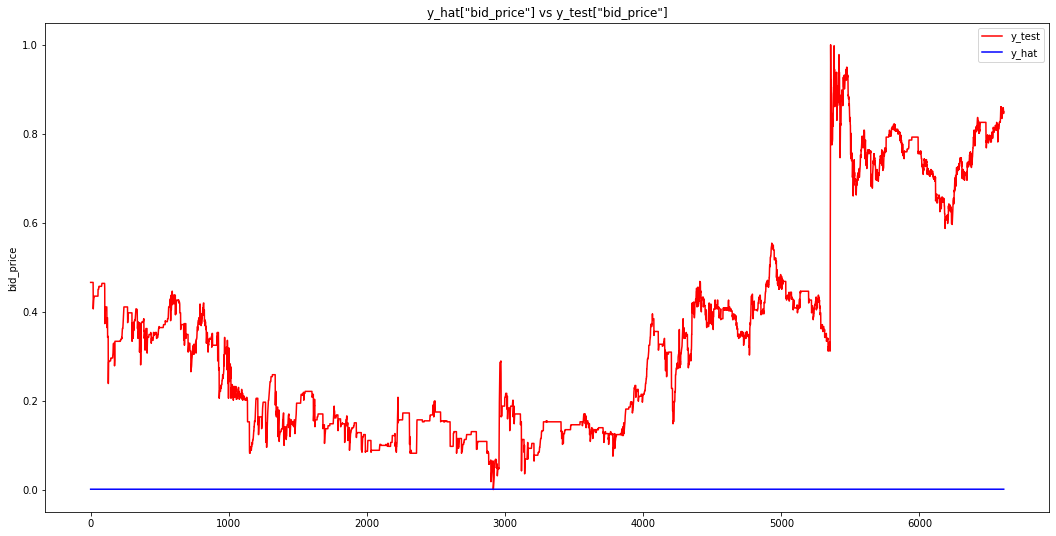

In [46]:
# Visualise the ask_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test[:,0], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["ask_price"] vs y_test["ask_price"]')
plt.ylabel('ask_price')
plt.legend()
plt.show()

# Visualise the bid_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test[:,3], color = 'red', label = 'y_test')
plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
plt.title('y_hat["bid_price"] vs y_test["bid_price"]')
plt.ylabel('bid_price')
plt.legend()
plt.show()